In [ ]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pickle
import base64
import sys

import hashlib
import json
from time import time
from time import sleep
import requests

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from torch import tensor
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassPrecision

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pickle

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/BC+FL Code/datasets/train_set.pickle', 'rb') as fp:
  train_dataset = pickle.load(fp)

with open('/content/gdrive/MyDrive/Colab Notebooks/BC+FL Code/datasets/test_set.pickle', 'rb') as fp:
  test_dataset = pickle.load(fp)

with open('/content/gdrive/MyDrive/Colab Notebooks/BC+FL Code/datasets/dev_set.pickle', 'rb') as fp:
  dev_dataset = pickle.load(fp)

In [ ]:
classes = 10
input_dim = 784

batch_size = 128
epochs_per_client = 3 # Misnomer: this number of epochs used, but not for indivdual clients in single model baseline
learning_rate = 2e-2

In [ ]:
rounds = 20

In [ ]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [ ]:
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        precision = MulticlassPrecision(num_classes=10).to(device)
        precision_score = precision(outputs, labels)
        recall = MulticlassRecall(num_classes=10).to(device)
        recall_score = recall(outputs, labels)
        return (loss, accuracy, precision_score, recall_score)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            prec_list = []
            rec_list = []
            for batch in dataloader:
                loss, acc, prec, rec = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
                prec_list.append(prec)
                rec_list.append(rec)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            avg_prec = torch.stack(prec_list).mean().item()
            avg_rec = torch.stack(rec_list).mean().item()
            f1 = (2*avg_prec*avg_rec) / (avg_prec + avg_rec)
            history.append((avg_loss, avg_acc, avg_prec, avg_rec, f1))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        prec_list = []
        rec_list = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc, prec, rec = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
                prec_list.append(prec)
                rec_list.append(rec)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        avg_prec = torch.stack(prec_list).mean().item()
        avg_rec = torch.stack(rec_list).mean().item()
        f1 = (2*avg_prec*avg_rec) / (avg_prec + avg_rec)
        return (avg_loss, avg_acc, avg_prec, avg_rec, f1)

In [ ]:
global_net = to_device(FederatedNet(), device)
history = []
prf = []
acc_hist = []

In [ ]:
for i in range(rounds):
  train_history = global_net.fit(train_dataset, epochs_per_client, learning_rate, batch_size)
  print('Training: Loss = {}, Accuracy = {}, Precision = {}, Recall = {}, F1 = {}'.format(round(train_history[-1][0], 4), round(train_history[-1][1], 4), round(train_history[-1][2], 4), round(train_history[-1][3], 4), round(train_history[-1][4], 4)))
  train_loss = round(train_history[-1][0])
  train_acc = round(train_history[-1][1])
  dev_loss, dev_acc, dev_prec, dev_rec, dev_f1 = global_net.evaluate(dev_dataset)
  print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}, dev_prec = {}, dev_rec = {}, dev_f1 = {}'.format(i+1, round(train_loss, 4),
              round(dev_loss, 4), round(dev_acc, 4), round(dev_prec, 4), round(dev_rec, 4), round(dev_f1, 4)))
  history.append((train_loss, dev_loss))
  prf.append((dev_prec, dev_rec, dev_f1))
  acc_hist.append((train_acc, dev_acc))


Training: Loss = 0.1196, Accuracy = 0.9658, Precision = 0.966, Recall = 0.9656, F1 = 0.9658
After round 1, train_loss = 0, dev_loss = 0.0987, dev_acc = 0.9711, dev_prec = 0.9706, dev_rec = 0.9707, dev_f1 = 0.9706
Training: Loss = 0.0717, Accuracy = 0.9788, Precision = 0.979, Recall = 0.9784, F1 = 0.9787
After round 2, train_loss = 0, dev_loss = 0.0707, dev_acc = 0.9795, dev_prec = 0.9799, dev_rec = 0.9794, dev_f1 = 0.9796
Training: Loss = 0.0555, Accuracy = 0.9837, Precision = 0.9841, Recall = 0.9832, F1 = 0.9836
After round 3, train_loss = 0, dev_loss = 0.0621, dev_acc = 0.9817, dev_prec = 0.982, dev_rec = 0.9817, dev_f1 = 0.9818
Training: Loss = 0.0469, Accuracy = 0.9857, Precision = 0.9857, Recall = 0.9856, F1 = 0.9857
After round 4, train_loss = 0, dev_loss = 0.0553, dev_acc = 0.9828, dev_prec = 0.9829, dev_rec = 0.9829, dev_f1 = 0.9829
Training: Loss = 0.0386, Accuracy = 0.9888, Precision = 0.9888, Recall = 0.9886, F1 = 0.9887
After round 5, train_loss = 0, dev_loss = 0.05, dev_ac

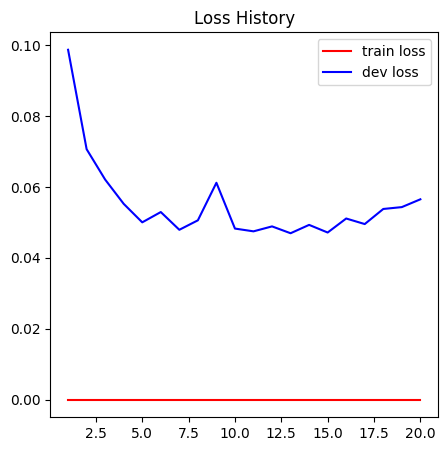

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Loss History')
plt.show()

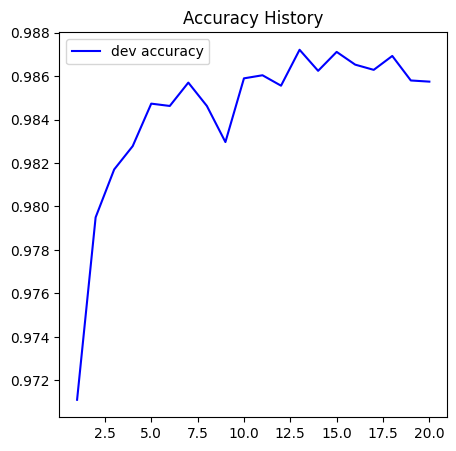

In [ ]:
plt.plot([i + 1 for i in range(len(acc_hist))], [acc_hist[i][1] for i in range(len(acc_hist))], color='b', label='dev accuracy')
plt.legend()
plt.title('Accuracy History')
plt.show()

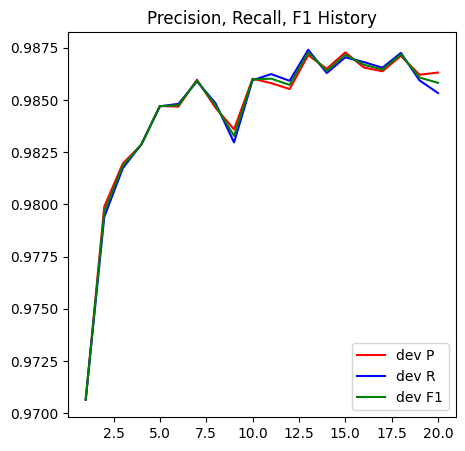

In [ ]:
plt.plot([i + 1 for i in range(len(prf))], [prf[i][0] for i in range(len(prf))], color='r', label='dev P')
plt.plot([i + 1 for i in range(len(prf))], [prf[i][1] for i in range(len(prf))], color='b', label='dev R')
plt.plot([i + 1 for i in range(len(prf))], [prf[i][2] for i in range(len(prf))], color='g', label='dev F1')
plt.legend()
plt.title('Precision, Recall, F1 History')
plt.show()

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1 = global_net.evaluate(test_dataset)
print('Final Test Evaluation, Loss = {}, Acc = {}, Prec = {}, Rec = {}, F1 = {}\n'.format(round(test_loss, 4),
             round(test_acc, 4), round(test_prec, 4), round(test_rec, 4), round(test_f1, 4)))

Final Test Evaluation, Loss = 0.0441, Acc = 0.9875, Prec = 0.9875, Rec = 0.9878, F1 = 0.9877

